[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/data_augmentation/ae/ae_cnn_residual.ipynb)


In [ ]:
import torch
import cv2
import torchvision
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.optim import Adam
from matplotlib import pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
!git clone https://github.com/khetansarvesh/CV.git

Cloning into 'CV'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 538 (delta 152), reused 134 (delta 58), pack-reused 268
Receiving objects: 100% (538/538), 26.92 MiB | 30.97 MiB/s, done.
Resolving deltas: 100% (301/301), done.


# **Dataset**

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Define the transformation to normalize the data between 1 and -1 (mean = 0.5 and variance = 0.5 will transform to values between 1 and -1)
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # downloading the MNIST train dataset and then applying some transformations
mnist_loader = DataLoader(dataset=mnist, batch_size=64, shuffle=True, num_workers=0) # loading the downloaded dataset

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14453731.73it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 488609.96it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4297311.65it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10214760.73it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# **Modelling**

In [ ]:
from CV.representation_learning.residual_block_utils import ResidualBlock

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
                                      nn.Conv2d(1, 128, 3, 1, 1), nn.GroupNorm(num_groups=32, num_channels=128, eps=1e-6, affine=True),nn.ReLU(),
                                      ResidualBlock(128, 256),
                                      nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.GroupNorm(num_groups=32, num_channels=256, eps=1e-6, affine=True),nn.ReLU(),
                                      nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.GroupNorm(num_groups=32, num_channels=256, eps=1e-6, affine=True),nn.ReLU(),
                                    )

        self.middle_block = nn.Sequential(
                                            ResidualBlock(256, 256),
                                            nn.Conv2d(256, 512, 3, 1, 1), nn.GroupNorm(num_groups=32, num_channels=512, eps=1e-6, affine=True),nn.ReLU(),
                                            ResidualBlock(512, 256),
                                          )

        self.decoder = nn.Sequential(
                                      nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1), nn.GroupNorm(num_groups=32, num_channels=256, eps=1e-6, affine=True),nn.ReLU(),
                                      ResidualBlock(256, 128),
                                      ResidualBlock(128, 128),
                                      nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1), nn.GroupNorm(num_groups=32, num_channels=128, eps=1e-6, affine=True),nn.ReLU(),

                                      #ResidualBlock(128, 128),
                                      #ResidualBlock(128, 128),
                                      #ResidualBlock(128, 128),
                                      #nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),


                                      nn.Conv2d(128, 1, 3, 1, 1)
                                      )

    def forward(self, x):
        encoded = self.encoder(x)
        # print(encoded.shape)
        middle_block = self.middle_block(encoded)
        # print(middle_block.shape)
        decoded = self.decoder(middle_block)
        # print(decoded.shape)
        return decoded

# **Training**

In [ ]:
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
for epoch_idx in range(20): # Run training for 10 epochs

    losses = []

    for im, _ in tqdm(mnist_loader):

        im = im.float().to(device)
        optimizer.zero_grad()

        # passing to model
        out = model(im)

        # loss calculation
        loss = nn.MSELoss()(im, out)

        # housekeeping
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    print(f'''Finished epoch:{epoch_idx+1} | KL Loss : {np.mean(losses)} ''')

100%|██████████| 938/938 [01:58<00:00,  7.90it/s]


Finished epoch:1 | KL Loss : 0.020542046072324918 


 32%|███▏      | 304/938 [00:37<01:19,  7.98it/s]

# **Inference**

In [ ]:
# Getting 100 random indexes
idxs = torch.randint(0, len(mnist)-1, (10, ))

# using these indexes to get images from mnist dataset and concatenating them
test_ims = torch.cat([mnist[idx][0][None, :] for idx in idxs]).float()

# generating images for the above test dataset
generated_im = model(test_ims.to(device))

In [ ]:
generated_im = torch.clamp(generated_im, -1., 1.).detach().cpu() # clamping the generated images
generated_im = 0.5*generated_im + 0.5 #detransforming the images from [-1,1] to [0,1]

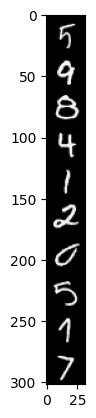

In [ ]:
# now printing the predicted images
grid = torchvision.utils.make_grid(generated_im, nrow=1)
img = torchvision.transforms.ToPILImage()(grid)
plt.imshow(img, cmap='gray')